# PyTorch Tutorial

### I. Przypomnienie Regresji Logistycznej

Regresja logistyczna to metoda **klasyfikacji**. Uczenie jest nadzorowane, więc mamy $N$ przykładów treningowych postaci $\{(x_i, y_i): i=1 \dots N\}$, gdzie $y_i$ jest dyskretną etykietą dla wektora cech $x_i=[x_{i1},\dots,x_{iD}]$.

##### 1. Binarna Regresja Logistyczna

By uzyskać odpowiedź modelu, dla danego wektora cech $x \in \mathbb{R}^D$ obliczany jest najpierw **logit** przy pomocy przekształcenia liniowego:

\begin{equation*}
l(x; a, b) = \ln\left(\frac{p(x; a, b)}{1-p(x; a, b)}\right) = xa^T + b,
\end{equation*}

gdzie wektor wag $a \in \mathbb{R}^D$ i skalar $b \in \mathbb{R}$ (zwany biasem) to parametry modelu. Dla uproszczenia można założyć $x = [1, x_1, \dots, x_D]$, wtedy $a = [b, a_1, \dots, a_D]$ i wzór się upraszcza:

\begin{equation*}
l(x; a) = xa^T \in \mathbb{R}.
\end{equation*}

Prawdopodobieństwo $0 \leq p \leq 1$ dla danego wektora $x$ można odtworzyć przy pomocy **funkcji logistycznej** $\sigma(t)=\frac{1}{1+e^{-t}}$:


\begin{equation*}
p(x;a) = \sigma(l(x;a)) = \frac{1}{1+e^{-l(x;a)}}.
\end{equation*}

Celem będzie maksymalizacja funkcji **log-likelihood** ([więcej](https://stats.stackexchange.com/questions/304988/understanding-the-logistic-regression-and-likelihood)), co jest tożsame z minimalizacją **entropii krzyżowej** (ang. cross entropy):

\begin{equation*}
\ell(X,Y; a) = \sum_{i=1}^N y_i \log(p(x_i;a)) + (1-y_i) \log(1 - p(x_i;a)).
\end{equation*}

Funkcję kosztu będziemy optymalizować gradientowo.

##### 2. Wieloklasowa Regresja Logistyczna

W przypadku klasyfikacji $K$-klasowej potrzebne jest stworzenie $K$ liniowych predyktorów zamiast jednego. Można łatwo tego dokonać zastępując wektor $a$ macierzą wag $A \in \mathbb{R}^{K \times (D+1)}$, w której $i$-ty wiersz odpowiada $i$-temu predyktorowi:

\begin{equation}
l(x; A) = xA^T \in \mathbb{R}^K.
\end{equation}

*Uwaga: Chociaż wynik tej operacji, z matematycznego punktu widzenia, nie powinien być traktowany już jako logit (logarytm szans), to w uczeniu maszynowym zwyczajowo taki wynikowy wektor dla klasyfikacji nazywa się logitami.*

Odpowiednikiem funkcji logistycznej dla przypadku wieloklasowego jest **softmax**$: \mathbb{R}^K \rightarrow \mathbb{R}^K$:

\begin{equation}
p(x;A)_i = \operatorname{softmax}(l(x;A))_i = \frac{e^{l(x;A)_i}}{\sum_{k=1}^Ke^{l(x;A)_k}},
\end{equation}

a funkcją kosztu ponownie jest **entropia krzyżowa** (minimalizujemy):

\begin{equation}
L(X,Y; A) = \frac{1}{N} \sum_{i=1}^N -\ell(x_i, y_i; A), \\
-\ell(x,y; A) = - \sum_{i=1}^K t_i \log(p(x;A)_i) = - \log(\operatorname{softmax}(l(x;A))_y),
\end{equation}

gdzie $t$ jest wektorem one-hot ([więcej](https://medium.com/@michaeldelsole/what-is-one-hot-encoding-and-how-to-do-it-f0ae272f1179)) dla etykiety $y$.

### II. Implementacja w Numpy

W ramach przypomnienia biblioteki Numpy do uzupełnienia będzie kod wieloklasowej regresji logistycznej. Do aktualizacji wag metodą spadku gradientu potrzebne będą pochodne implementowanych funkcji, podane poniżej.


##### 1. Pochodne

Funkcja kosztu względem logitów ([przykładowe wyprowadzenie](https://deepnotes.io/softmax-crossentropy)):

\begin{equation}
\frac{\partial -\ell}{\partial l_i} = \operatorname{softmax}(l)_i - t_i.
\end{equation}

Pochodna predyktora liniowego:

\begin{equation}
\frac{\partial l_i}{\partial a_{ij}} = x_j, \quad \forall k \neq i: \frac{\partial l_i}{\partial a_{kj}} = 0.
\end{equation}

Pochodna kosztu po wagach:

\begin{equation}
\frac{\partial -\ell}{\partial a_{ij}} = \sum_{k=1}^K \frac{\partial -\ell}{\partial l_k} \frac{\partial l_k}{\partial a_{ij}} = \frac{\partial -\ell}{\partial l_i} \frac{\partial l_i}{\partial a_{ij}} = (\operatorname{softmax}(l)_i - t_i) \cdot x_j.
\\
\frac{\partial L}{\partial a_{ij}} = \frac{1}{N} \sum_{i=1}^N \frac{\partial -\ell(x_i)}{\partial a_{ij}}
\end{equation}

##### 2. Implementacja

Należy uzupełnić kod w oznaczonych miejscach tak, aby powstał model regresji logistycznej optymalizowanej metodą spadku gradientu. Do treningu będziemy używać pomniejszonego 10-krotnie zbioru MNIST. Zbiór zawiera obrazy 28x28 ręcznie pisanych cyfr (widoczne poniżej). Wejściem do modelu będzie wektor kolejnych 784 pikseli obrazów i dodatkowa wartość 1 odpowiedzialna za bias.

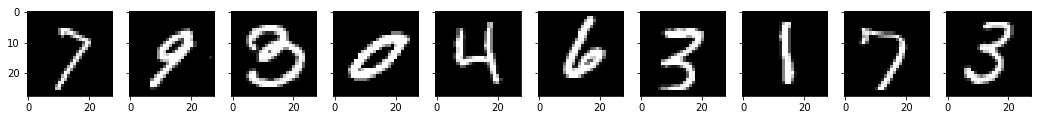

train data shape: (5000, 785), test data shape: (1000, 785)


In [1]:
# Import MNIST dataset

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

def load_dataset(dataset_name):
    data = np.load('data/{}/{}.npz'.format(dataset_name.upper(), dataset_name))
    return data['X_train'], data['y_train'], data['X_test'], data['y_test']

X_train, y_train, X_test, y_test = load_dataset('mini_mnist')

f, ax = plt.subplots(1, 10, sharex='col', sharey='row',figsize=(18, 16))
for a in ax:
    a.imshow(X_train[np.random.randint(X_train.shape[0])].reshape(28, 28), cmap='gray')
plt.show()

X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]
print("train data shape: {}, test data shape: {}".format(X_train.shape, X_test.shape))

In [11]:
def np_linear(x, a):
    '''
    Calculate l(x;a) in BxK
    
    :param x: Bx(D+1) input data
    :param a: Kx(D+1) weight matrix
    '''
    return np.dot(x, a.T)

def np_softmax(l):
    '''
    Calculate p(l) in BxK
    
    :param l: BxK logits
    '''
    normalize_val = np.exp(l - l.max())
    return normalize_val / np.sum(normalize_val, axis=1).reshape(-1, 1)
    
from sklearn import preprocessing
def np_cross_entropy(p, y):
    '''
    Calculate L(p,y)
    
    :param p: BxK predictions
    :param y: B true labels
    '''
    vals = p[range(y.shape[0]), y]
    return -np.mean(np.log(vals), axis=0)

def np_cross_entropy_grad(p, y, x):
    '''
    Calculate dL/da in Kx(D+1)
    
    :param p: BxK predictions
    :param y: B true labels
    :param x: Bx(D+1) input data
    '''
    y_one_hotted = np.zeros((y.size, y.max()+1))
    y_one_hotted[np.arange(y.size), y] = 1
    return np.dot(x.T, (p - np.vstack(y_one_hotted))) / y_one_hotted.shape[0] 

class NumpyLogisticRegression:
        
    def __init__(self, n_classes, n_epochs, input_size, learning_rate=0.1, batch_size=256):
        self.A = np.zeros((n_classes, input_size))
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.input_size = input_size
        self.n_classes = n_classes
        self.n_epochs = n_epochs
    
    def forward(self, x):
        lin = np_linear(x, self.A)
        return np_softmax(lin)
    
    def train(self, X, Y, X_test=None, y_test=None):
        loss, train_accuracy, test_accuracy = [], [], []
        
        for e in tqdm(range(self.n_epochs)):
            
            perm = np.random.permutation(len(X))
            X, Y, = X[perm], Y[perm]
            
            for batch in range(len(X) // self.batch_size):
                x = X[batch * self.batch_size:(batch + 1) * self.batch_size]
                y = Y[batch * self.batch_size:(batch + 1) * self.batch_size]
                
                p = self.forward(x)
                l = np_cross_entropy(p, y)
                loss.append(l)
                train_accuracy.append(self.test(x, y))
                if X_test is not None and y_test is not None:
                    test_accuracy.append(self.test(X_test, y_test))
                
                grad_A = np_cross_entropy_grad(p, y, x)# calculate gradient
                self.A -= grad_A * self.learning_rate
                
        return loss, train_accuracy, test_accuracy
    
    def test(self, X, Y):
        p = np.argmax(self.forward(X), axis=1)
        return np.mean(p == Y)

In [12]:
clf = NumpyLogisticRegression(n_classes=10, n_epochs=10, input_size=785)
loss, train_accuracy, test_accuracy = clf.train(X_train, y_train, X_test, y_test)

100%|██████████| 10/10 [00:01<00:00,  9.82it/s]


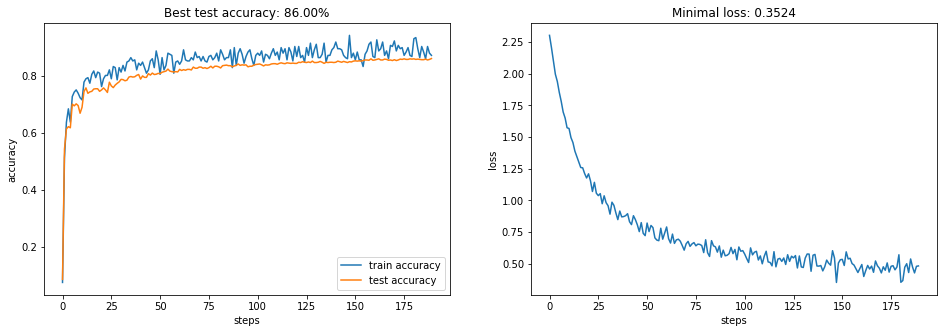

In [13]:
def show_results(loss, train_accuracy, test_accuracy):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    ax1.set_title("Best test accuracy: {:.2f}%".format(max(test_accuracy) * 100))
    ax1.plot(train_accuracy, label='train accuracy')
    ax1.plot(test_accuracy, label='test accuracy')
    ax1.set_xlabel('steps')
    ax1.set_ylabel('accuracy')
    ax1.legend()

    ax2.set_title("Minimal loss: {:.4f}".format(min(loss)))
    ax2.plot(loss)
    ax2.set_xlabel('steps')
    ax2.set_ylabel('loss')

    plt.show()
    
show_results(loss, train_accuracy, test_accuracy)

### Testy

In [14]:
x = np.array([[1.5, -2., 9.], [6., -1.2, 4.]])
A = np.array([
    [1., 2., 3.],
    [6., 5., 4.]
])

l = np.array([
    [ 24.5,  35. ],
    [ 15.6,  46. ]
])

p = np.array([
    [2.75356911e-05, 9.99972464e-01],
    [  6.27260226e-14,   1.]
])

y = np.array([0, 1])
ce = 5.250013768

assert np.allclose(np_linear(x, A), l)
assert np.allclose(np_softmax(l), p)
assert np.allclose(np_cross_entropy(p, y), ce)

print("OK!")

OK!


### III. Implementacja w PyTorchu

##### 1. Wstęp do PyTorcha

W PyTorchu odpowiednikiem Numpy'owych tablic (np.array) są tensory (torch.Tensor) - tworzy się je analogicznie i dostępne są dla nich podobne operacje.

In [15]:
import torch

# wartości można podać bezpośrednio do tensora
a = torch.Tensor([[1, 2], [3, 4]])  
print(a)

# tensor wypełniony jedynkami o wymiarach 2x2
b = torch.ones((2, 2))  
print(b)

# macierz identycznościowa 7x7
c = torch.eye(7, 7)
print(c)

# tensor wypełniony losowymi wartościami N(0,1) o wymiarach 2x1x2
d = torch.randn((2, 1, 2))  
print(d)

tensor([[1., 2.],
        [3., 4.]])
tensor([[1., 1.],
        [1., 1.]])
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1.]])
tensor([[[ 0.7341, -0.1694]],

        [[ 0.0775, -1.2256]]])


In [16]:
# Broadcasting działa podobnie jak w Numpy
# a ma wymiar 2x2, d ma wymiar 2x1x2, więc wynik będzie miał wymiar 2x2x2
print((a + d).size()) 

# Działania mają swoje odpowiedniki "w miejscu" oznaczone znakiem "_" na końcu nazwy metody
# Uwaga: w tym przypadku broadcasting nie może zmieniać wymiaru tensora!
# a = a + b
a.add_(b)  
print(a)

torch.Size([2, 2, 2])
tensor([[2., 3.],
        [4., 5.]])


In [17]:
# Istnieją odpowiedniki funkcji z Numpy, np.
print(torch.log(a))        # odpowiednik np.log
print(torch.matmul(a, b))  # odpowiednik np.matmul, również w formie skróconej torch.mm
print(torch.sum(a))        # odpowiednik np.sum
print(a.view(1, 1, 4))     # odpowiednik x.reshape(1, 1, 4)

tensor([[0.6931, 1.0986],
        [1.3863, 1.6094]])
tensor([[5., 5.],
        [9., 9.]])
tensor(14.)
tensor([[[2., 3., 4., 5.]]])


In [18]:
# Tensory mogą mieć różne typy, zaznacza się urządzenie (CPU/GPU) tensora
print(torch.Tensor([1]))             # tensor domyślnego typu torch.float
print(torch.FloatTensor([1]))        # tensor typu torch.float
print(torch.cuda.DoubleTensor([1]))  # tensor typu torch.double na GPU
print(torch.cuda.LongTensor([1]))    # tensor typu torch.long na GPU

# Tensory mogą być też tworzone konstruktorem torch.tensor
print(torch.tensor([1], device='cuda', dtype=torch.float))

# Zmienne modelu, dla których ma być liczony gradient, oznacza się parametrem requires_grad
print(torch.tensor([1.], requires_grad=True))

tensor([1.])
tensor([1.])


AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

##### 2. Implementacja Regresji Logistycznej w PyTorchu

Należy uzupełnić kod analogicznie do modelu Numpy.

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
X_train = torch.tensor(X_train, dtype=torch.float, device=device)
X_test = torch.tensor(X_test, dtype=torch.float, device=device)
y_train = torch.tensor(y_train, dtype=torch.long, device=device)
y_test = torch.tensor(y_test, dtype=torch.long, device=device)

In [21]:
def t_linear(x, a):
    '''
    Calculate l(x;a) in BxK
    
    :param x: Bx(D+1) input data
    :param a: Kx(D+1) weight matrix
    '''
    return torch.mm(x, torch.t(a))
    
def t_softmax(l):
    '''
    Calculate p(l) in BxK
    
    :param l: BxK logits
    '''
    normalize_val = torch.exp(l - l.max())
    return normalize_val / torch.sum(normalize_val, dim=1).unsqueeze(-1)
def t_cross_entropy(p, y):
    '''
    Calculate L(p,y)
    
    :param p: BxK predictions
    :param y: B true labels
    '''
    vals = p[range(y.shape[0]), y]
    return -1 * torch.mean(torch.log(vals), dim=0)

class TorchLogisticRegression:
    
    def __init__(self, n_classes, n_epochs, input_size, learning_rate=0.1, batch_size=256):
        self.A = torch.zeros((n_classes, input_size), requires_grad=True, device=device)
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.input_size = input_size
        self.n_classes = n_classes
        self.n_epochs = n_epochs
    
    def forward(self, x):
        lin = t_linear(x, self.A)
        return t_softmax(lin)
    
    def train(self, X, Y, X_test=None, y_test=None):
        loss, train_accuracy, test_accuracy = [], [], []
        
        for e in tqdm(range(self.n_epochs)):
            
            perm = torch.randperm(len(X))
            X, Y, = X[perm], Y[perm]
            
            for batch in range(len(X) // self.batch_size):
                x = X[batch * self.batch_size:(batch + 1) * self.batch_size]
                y = Y[batch * self.batch_size:(batch + 1) * self.batch_size]
                
                p = self.forward(x)
                l = t_cross_entropy(p, y)
                
                loss.append(l)
                train_accuracy.append(self.test(x, y))
                if X_test is not None and y_test is not None:
                    test_accuracy.append(self.test(X_test, y_test))
                
                # run backward from the loss
                l.backward()
                grad_A = self.A.grad 
                self.A.data -= grad_A * self.learning_rate
                self.A.grad.data.zero_()
                # zero gradients after calculations
                
        return loss, train_accuracy, test_accuracy
    
    def test(self, X, Y):
        p = torch.argmax(self.forward(X), dim=1)
        return torch.mean((p == Y).float())

In [22]:
clf = TorchLogisticRegression(n_classes=10, n_epochs=10, input_size=785)
loss, train_accuracy, test_accuracy = clf.train(X_train, y_train, X_test, y_test)

100%|██████████| 10/10 [00:00<00:00, 11.46it/s]


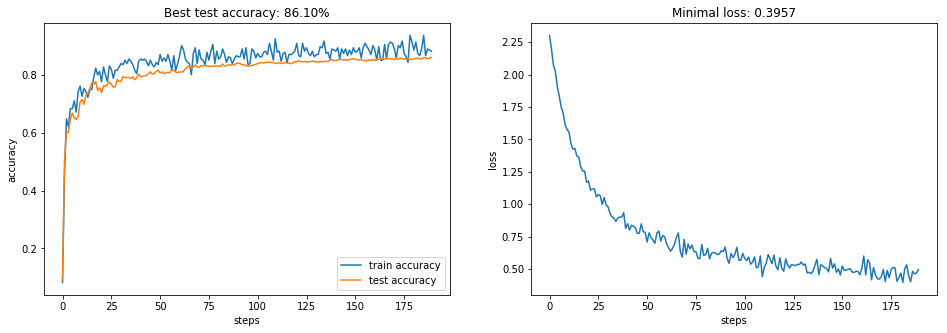

In [23]:
show_results(loss, train_accuracy, test_accuracy)

### Testy

In [25]:
tx = torch.Tensor([[1.5, -2., 9.], [6., -1.2, 4.]])
tA = torch.tensor([
    [1., 2., 3.],
    [6., 5., 4.]
], requires_grad=True, dtype=torch.float)
tl = torch.Tensor([
    [ 24.5,  35. ],
    [ 15.6,  46. ]
])
tp = torch.Tensor([
    [2.75356911e-05, 9.99972464e-01],
    [  6.27260226e-14,   1.]
])
ty = torch.LongTensor([0, 1])

assert torch.allclose(t_linear(tx, tA), tl)
assert torch.allclose(t_softmax(tl), torch.softmax(tl, dim=1))
assert torch.allclose(t_cross_entropy(tp, ty),torch.nn.CrossEntropyLoss()(tl, ty))

print("OK!")

OK!


### Oczekiwania od Rozwiązania

- Wykresy dla obu modeli (implementowanego w Numpy i PyTorchu) dają sensowe wykresy.
 - Przez sensowny wykres rozumiem, że funkcja kosztu maleje i wypłaszcza się, a dokładność wzrasta.
 - Wykresy dla obu modeli są podobne (modele powinny z założenia liczyć to samo z dokładnością do permutacji danych treningowych).
 - Dla domyślnych parametrów batch size i learning rate model powinien osiągać dokładność powyżej 86%.
- Zaimplementowane funkcje przechodzą wszystkie załączone testy.
- (opcjonalnie) Implementowane funkcje w Numpy powinny zawierać jak najmniej pętli ze względów wydajnościowych.